# Phase 2 - Model Tuning

In this worksheet the trained models are used and tuned to produce best results after reconstruction of the 3D segmented image. In this step, we will work with both - training and validation data, that had been used for the training of the nine neural networks. 

The manually segmented test record MNI_0663 will still not be touched during this stage of the process. It will only by used in the last stage of the project to assess the quality of the produced model against a formerly unseen cerebral MRA scan. 

In [75]:

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import MRASegmentation as mra

In [76]:
ground_truth_only = True # validate against the ground truth without segmenting image projections: yes / no 
                          # typically, to test performance of the model, set this to False

Load the 9 MRI records, that have been used during training (training + validation data): 

In [77]:
app = mra.MRASegmentation()

mra_trn = app.get_mra_source_ids()
mra_trn.remove('MNI_0663') # do not include in this exercise; this record is reserved for the final test (in Phase 3)

Next we construct the 3D raw segmentation map for each of the nine MRA scans (which assigns each pixel a value between 0 and 9). Pixels with value of 0 are set to be background. Pixels with value of 9 are set to be blood vessel, and a threshold value between 1 and 9 needs to be found that optimises the segmentation of data in the 3D prediction against the provided ground truth.  

In [78]:
# Load the parameter weightings of the nine UNet models (as produced during the training runs in Phase 1)
if not ground_truth_only: # we do only need to load the UNET models if we perform actual segmetation run
                          # and do not validate process against ground truth data themselves 
    app._unets.get_models()
    print('Initialisation complete and UNET models loaded')

Now we can load source / ground truth and predicted segmentation map for each record to conduct the final model tuning.
This process takes about 3min on my Computer

In [79]:
# Training data
l_src_map = np.ndarray(shape=(len(mra_trn),app._no_slices,app._img_height,app._img_height), dtype=np.uint16)  
l_gt_map  = np.ndarray(shape=(len(mra_trn),app._no_slices,app._img_height,app._img_height), dtype=np.uint16)   
l_seg_map = np.ndarray(shape=(len(mra_trn),app._no_slices,app._img_height,app._img_height), dtype=np.uint16) 
# set up debug directories if debug is enabled
if app._debug:
    app.set_up_debug_directories(mra_trn)
i=0
for mra_id in mra_trn: 
    app._mra_id = mra_id
    # Read in 3D MRA source data 
    l_src_map[i] = app.get_3d_mra_source(mra_id)  
    # Load the corresponding 3D Ground Truth image 
    l_gt_map[i] = np.sign(app.get_3d_mra_gt(mra_id)).astype(int)
    if ground_truth_only:
        # base the predicted ground truth map for the projection on its corresponding 3D GT version
        mra_seg_2Ds = app.get_2d_mra_gt_projs(l_gt_map[i])
    else:
        # construct the nine 2D MRA projections 
        mra_src_2Ds = app.get_2d_mra_src_projs(l_src_map[i]) 
        # run the nine unet processes across the image source projections (as trained in Phase 1)
        mra_seg_2Ds = app.get_2d_mra_seg_projs(mra_src_2Ds) 
    # Reconstruct the 3D segmented raw image 
    l_seg_map[i] = app.reconstruct_3d_segmentation(mra_seg_2Ds,l_src_map[i]).astype(int)
    print('MRA Scan '+mra_id+' 3D processed successfully.') 
    i = i+1


MRA Scan MNI_0656 3D processed successfully.


Next we evaluate the performance of the reconstructed 3D image maps against the corresponding ground truth, based on different threshold values for the data points in the voxel map. Each voxel is assigned a value between 0 and 9. 
- 0: voxel is almost certainly part of the background
- 9: voxel is almost certainly part of a blood vessel stream 

The following process determines an optimised threshold for distinction between blood vessel and background voxels

In [6]:
cnt_metrics = list() 


for n_hits in range(1, app.NO_PROJECTIONS + 1):
    print('Minimum Number of hits: ' + str(n_hits))
    print('******************************************')
    seg_map = (l_seg_map > n_hits - 1)
    
    diff = l_gt_map - (seg_map*2)
    fn = (diff==1).sum()
    tp = (diff==-1).sum()
    fp = (diff==-2).sum()
    tn = (diff==0).sum()
    p  = tp / (tp + fp)  # precision 
    r  = tp / (tp + fn)  # recall 
    f1 = 2*p*r/(p+r)     # F1 score
    cnt_metrics.append([n_hits,np.round(100*p,2),np.round(100*r,2),np.round(100*f1,2)])

    print('Precision:   ' + str(np.round(100*p,2))+'%')
    print('Recall:      ' + str(np.round(100*r,2))+'%')
    print('F1 Score:    ' + str(np.round(100*2*p*r/(p+r),2))+'%')
    print('    ')
    

Minimum Number of hits: 1
******************************************
Precision:   80.19%
Recall:      61.31%
F1 Score:    69.49%
    
Minimum Number of hits: 2
******************************************
Precision:   86.84%
Recall:      52.89%
F1 Score:    65.74%
    
Minimum Number of hits: 3
******************************************
Precision:   90.69%
Recall:      49.44%
F1 Score:    63.99%
    
Minimum Number of hits: 4
******************************************
Precision:   93.16%
Recall:      46.57%
F1 Score:    62.09%
    
Minimum Number of hits: 5
******************************************
Precision:   94.75%
Recall:      42.42%
F1 Score:    58.6%
    
Minimum Number of hits: 6
******************************************
Precision:   96.04%
Recall:      36.69%
F1 Score:    53.1%
    
Minimum Number of hits: 7
******************************************
Precision:   97.18%
Recall:      30.2%
F1 Score:    46.08%
    
Minimum Number of hits: 8
***************************************

Now we visualise the results

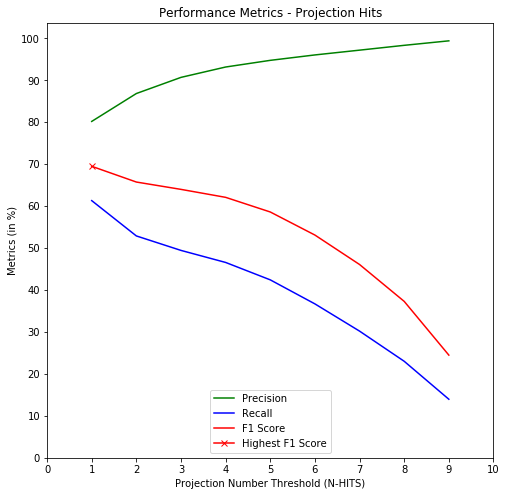

In [14]:
plt.figure(figsize=(8, 8))
plt.title("Performance Metrics - Projection Hits")
c = cnt_metrics
x = np.asarray(list([i[0] for i in c]))
p = np.asarray(list([i[1] for i in c]))
r = np.asarray(list([i[2] for i in c]))
f = np.asarray(list([i[3] for i in c]))
plt.plot(x,p, color="g", label="Precision")
plt.plot(x,r, color="b", label="Recall")
plt.plot(x,f, color="r", label="F1 Score")
plt.plot( x[np.argmax(f)], np.max(f), marker="x", color="r", label="Highest F1 Score")
idx=np.argmin(np.abs([p-r]))
#plt.annotate('',xy=(x[idx], r[idx]), xytext=(x[idx], r[idx]+30),
#            arrowprops=dict(facecolor='black', width=1,shrink=0.05),)

#plt.text(idx, r[idx]+30, s='Minimum Distance between Precision and Recall', fontsize=12,horizontalalignment='center')

plt.xticks(range(11))
plt.xlabel("Projection Number Threshold (N-HITS)")
#plt.ylim(0,100)
plt.yticks(range(0, 110, 10))
plt.ylabel("Metrics (in %)")
plt.legend(loc='lower center');

We work with a hit threshold of 5 for the initial segmentation of the MRA scan. Next we calculate the number of neighbouring blood vessel pixels for each pixel in the 3D map.

In [30]:
n_hits = 5
seg_map = (l_seg_map > n_hits - 1).astype(int)
n_map = seg_map * 0 # initialise empty map with zeros 
   
offset = [-1,0,1]
idx = np.where(seg_map == 1)
for i,x,y,z in zip(idx[0],idx[1],idx[2],idx[3]): 
    for ox in offset:
        for oy in offset:
            for oz in offset: 
                try: 
                    n_map[i,x+ox,y+oy,z+oz] = n_map[i,x+ox,y+oy,z+oz] + 1 
                except IndexError:
                    pass # Ignore when pixels on the boundaries of the cube raise index errors        


Calculate the optimal k value in n_map, when choosing the pixel threshold in the ini-file

In [9]:
k_metrics = list()
added = n_map * (l_src_map.astype(int) > app._pxl_threshold).astype(int)

for k in range(1,27):
    print('Minimum Number of neighbours: ' + str(k))
    print('******************************************')
    fixed = np.sign(seg_map + (added >= k).astype(np.uint16))
    
    
    diff = l_gt_map - (fixed*2)
    fn = (diff==1).sum()
    tp = (diff==-1).sum()
    fp = (diff==-2).sum()
    tn = (diff==0).sum()
    p  = tp / (tp + fp)  # precision 
    r  = tp / (tp + fn)  # recall 
    f1 = 2*p*r/(p+r)     # F1 score
    k_metrics.append([k, np.round(100*p,2), np.round(100*r,2), np.round(100*f1,2)])

    print('Precision:   ' + str(np.round(100*p,2))+'%')
    print('Recall:      ' + str(np.round(100*r,2))+'%')
    print('F1 Score:    ' + str(np.round(100*f1,2))+'%')
    print('    ')


Minimum Number of neighbours: 1
******************************************
Precision:   18.36%
Recall:      96.02%
F1 Score:    30.83%
    
Minimum Number of neighbours: 2
******************************************
Precision:   22.89%
Recall:      94.34%
F1 Score:    36.84%
    
Minimum Number of neighbours: 3
******************************************
Precision:   27.68%
Recall:      92.48%
F1 Score:    42.61%
    
Minimum Number of neighbours: 4
******************************************
Precision:   32.96%
Recall:      90.29%
F1 Score:    48.29%
    
Minimum Number of neighbours: 5
******************************************
Precision:   38.44%
Recall:      87.57%
F1 Score:    53.43%
    
Minimum Number of neighbours: 6
******************************************
Precision:   43.36%
Recall:      84.41%
F1 Score:    57.29%
    
Minimum Number of neighbours: 7
******************************************
Precision:   47.12%
Recall:      81.03%
F1 Score:    59.59%
    
Minimum Number of ne

Graph the loss function for parameter K

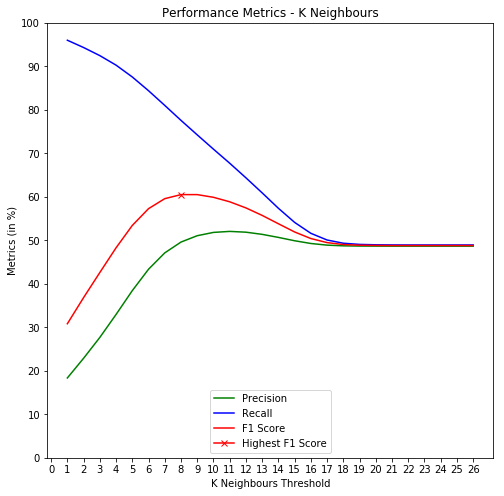

In [10]:
plt.figure(figsize=(8, 8))
plt.title("Performance Metrics - K Neighbours")
c = k_metrics
x = np.asarray(list([i[0] for i in c]))
p = np.asarray(list([i[1] for i in c]))
r = np.asarray(list([i[2] for i in c]))
f = np.asarray(list([i[3] for i in c]))
plt.plot(x,p, color="g", label="Precision")
plt.plot(x,r, color="b", label="Recall")
plt.plot(x,f, color="r", label="F1 Score")
plt.plot( x[np.argmax(f)], np.max(f), marker="x", color="r", label="Highest F1 Score")
plt.xticks(range(27))
plt.xlabel("K Neighbours Threshold")
#plt.ylim(0,100)
plt.yticks(range(0, 110, 10))
plt.ylabel("Metrics (in %)")
plt.legend(loc='lower center')

THE FINAL MODEL WILL BE CONFIGURED WITH N_HITS = 5 and K = 9

# VISUALISATION OF SEGMENTATION RESULTS

In [80]:
idx = 0
l_src = l_src_map[idx]
l_seg = l_seg_map[idx]
l_gt  = l_gt_map[idx]
print(mra_trn[idx])


MNI_0656


In [81]:
from mpl_toolkits.mplot3d import Axes3D

def display_3d_image (data_points, cols):
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(111, projection='3d')
    i = 0
    for dp in data_points.keys():
        ax.scatter(data_points[dp][2], data_points[dp][1], data_points[dp][0], c=cols[i], marker='o',s=0.5)
        i = i + 1

    plt.xlim(0, len(l_seg[1,1,:]))
    plt.ylim(0, len(l_seg[1,:,1]))
    ax.set_xlabel('Image Slices')
    ax.set_ylabel('X Pixel')
    ax.set_zlabel('Y Pixel')

    plt.show()

Visualise ground truth data

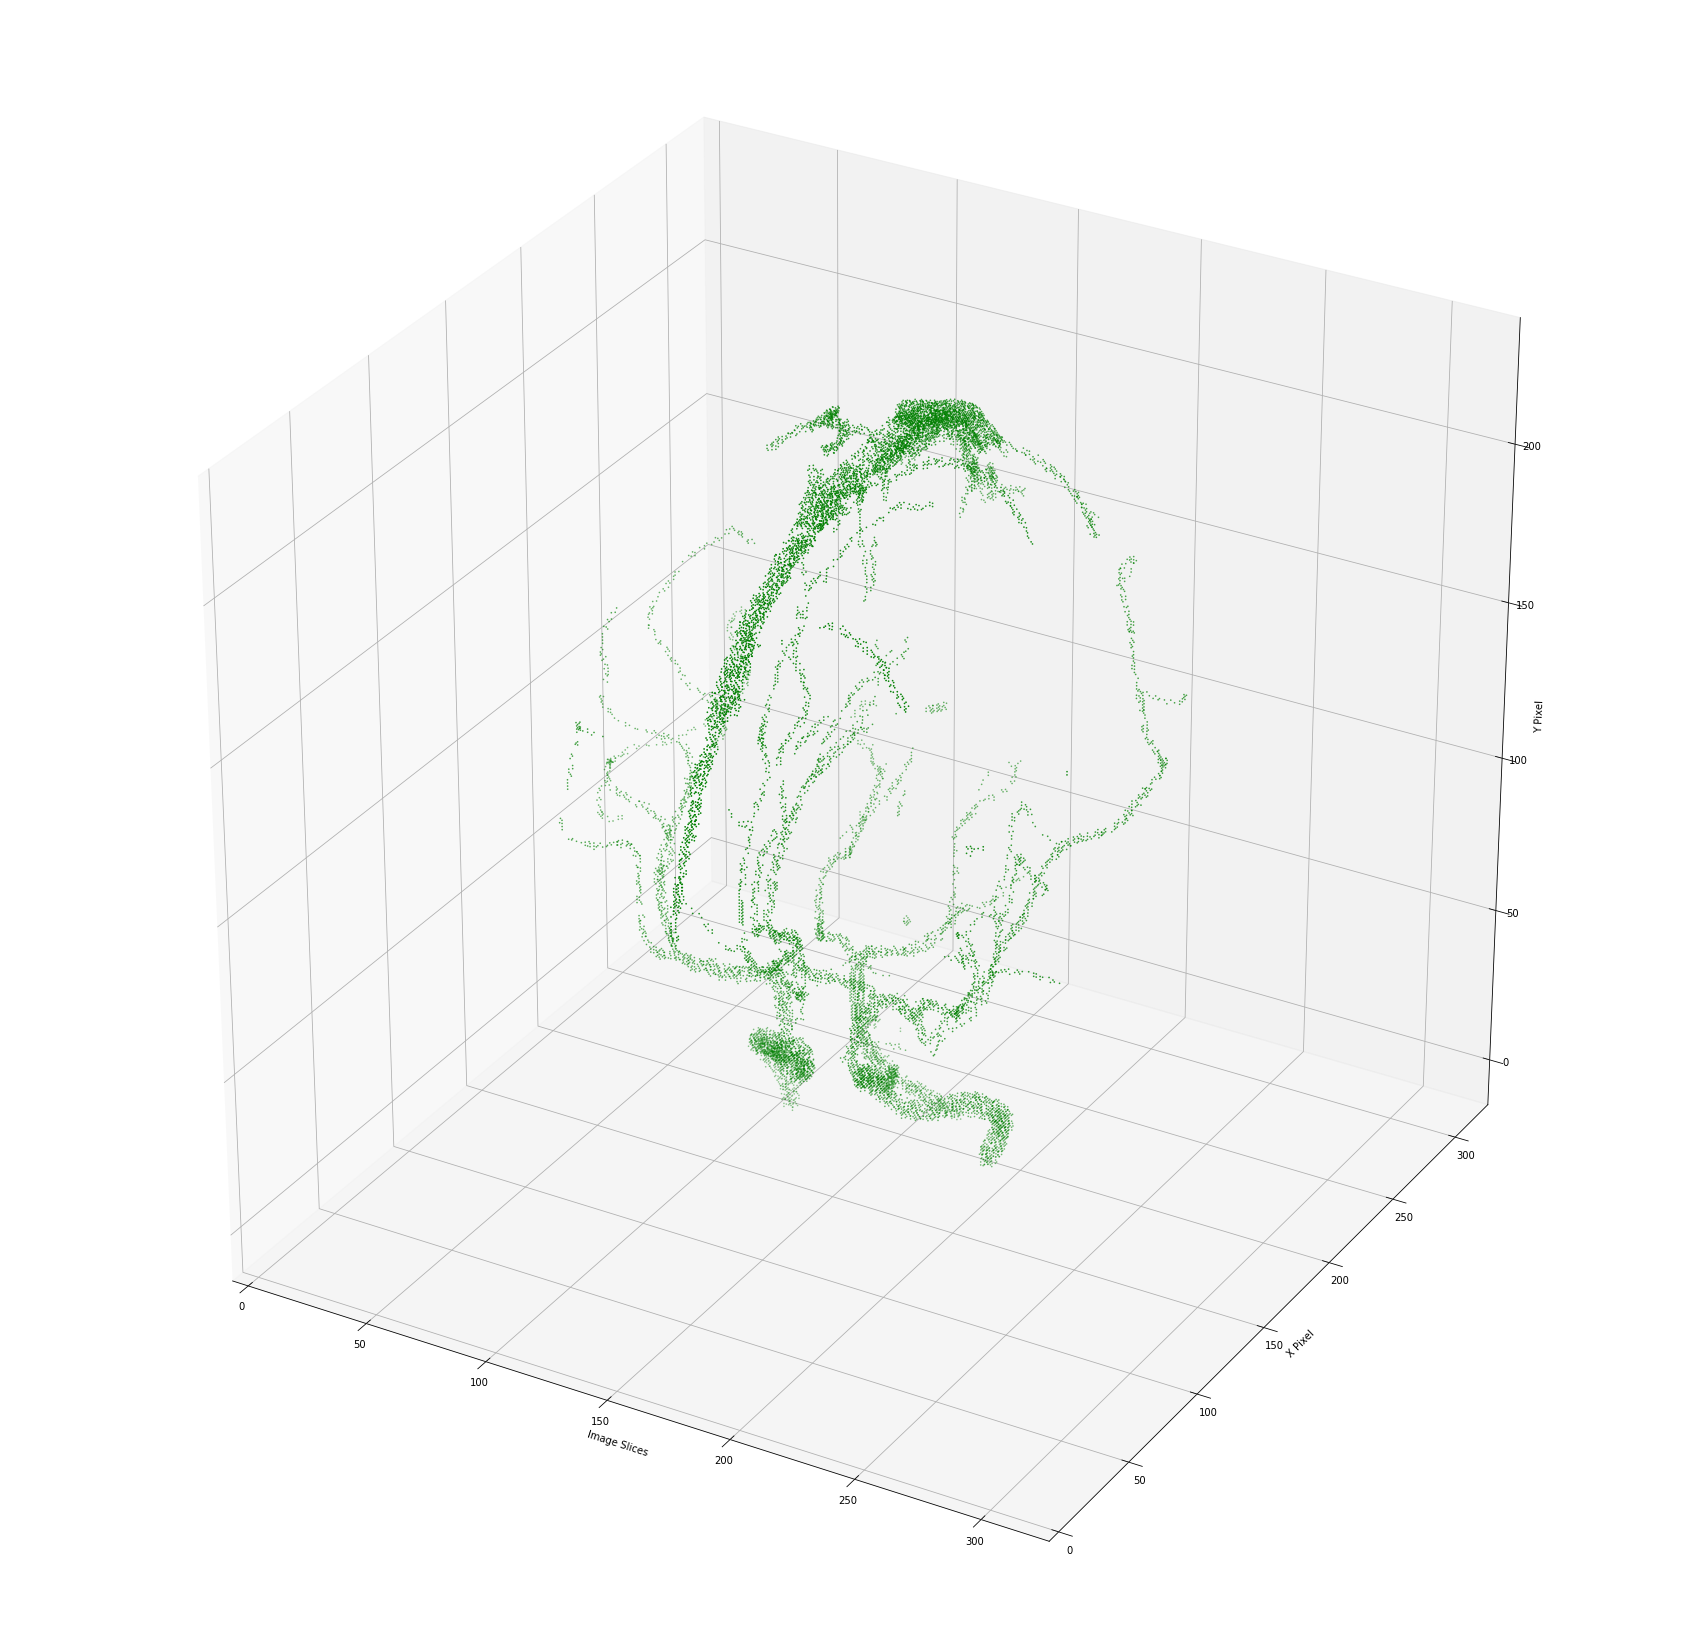

In [82]:
ll = dict()
i = np.equal(l_gt, 1)
ll[0] = np.where(i)

display_3d_image (ll, ['green'])

Visualise with selected threshold

Minimum Number of hits: 5
******************************************


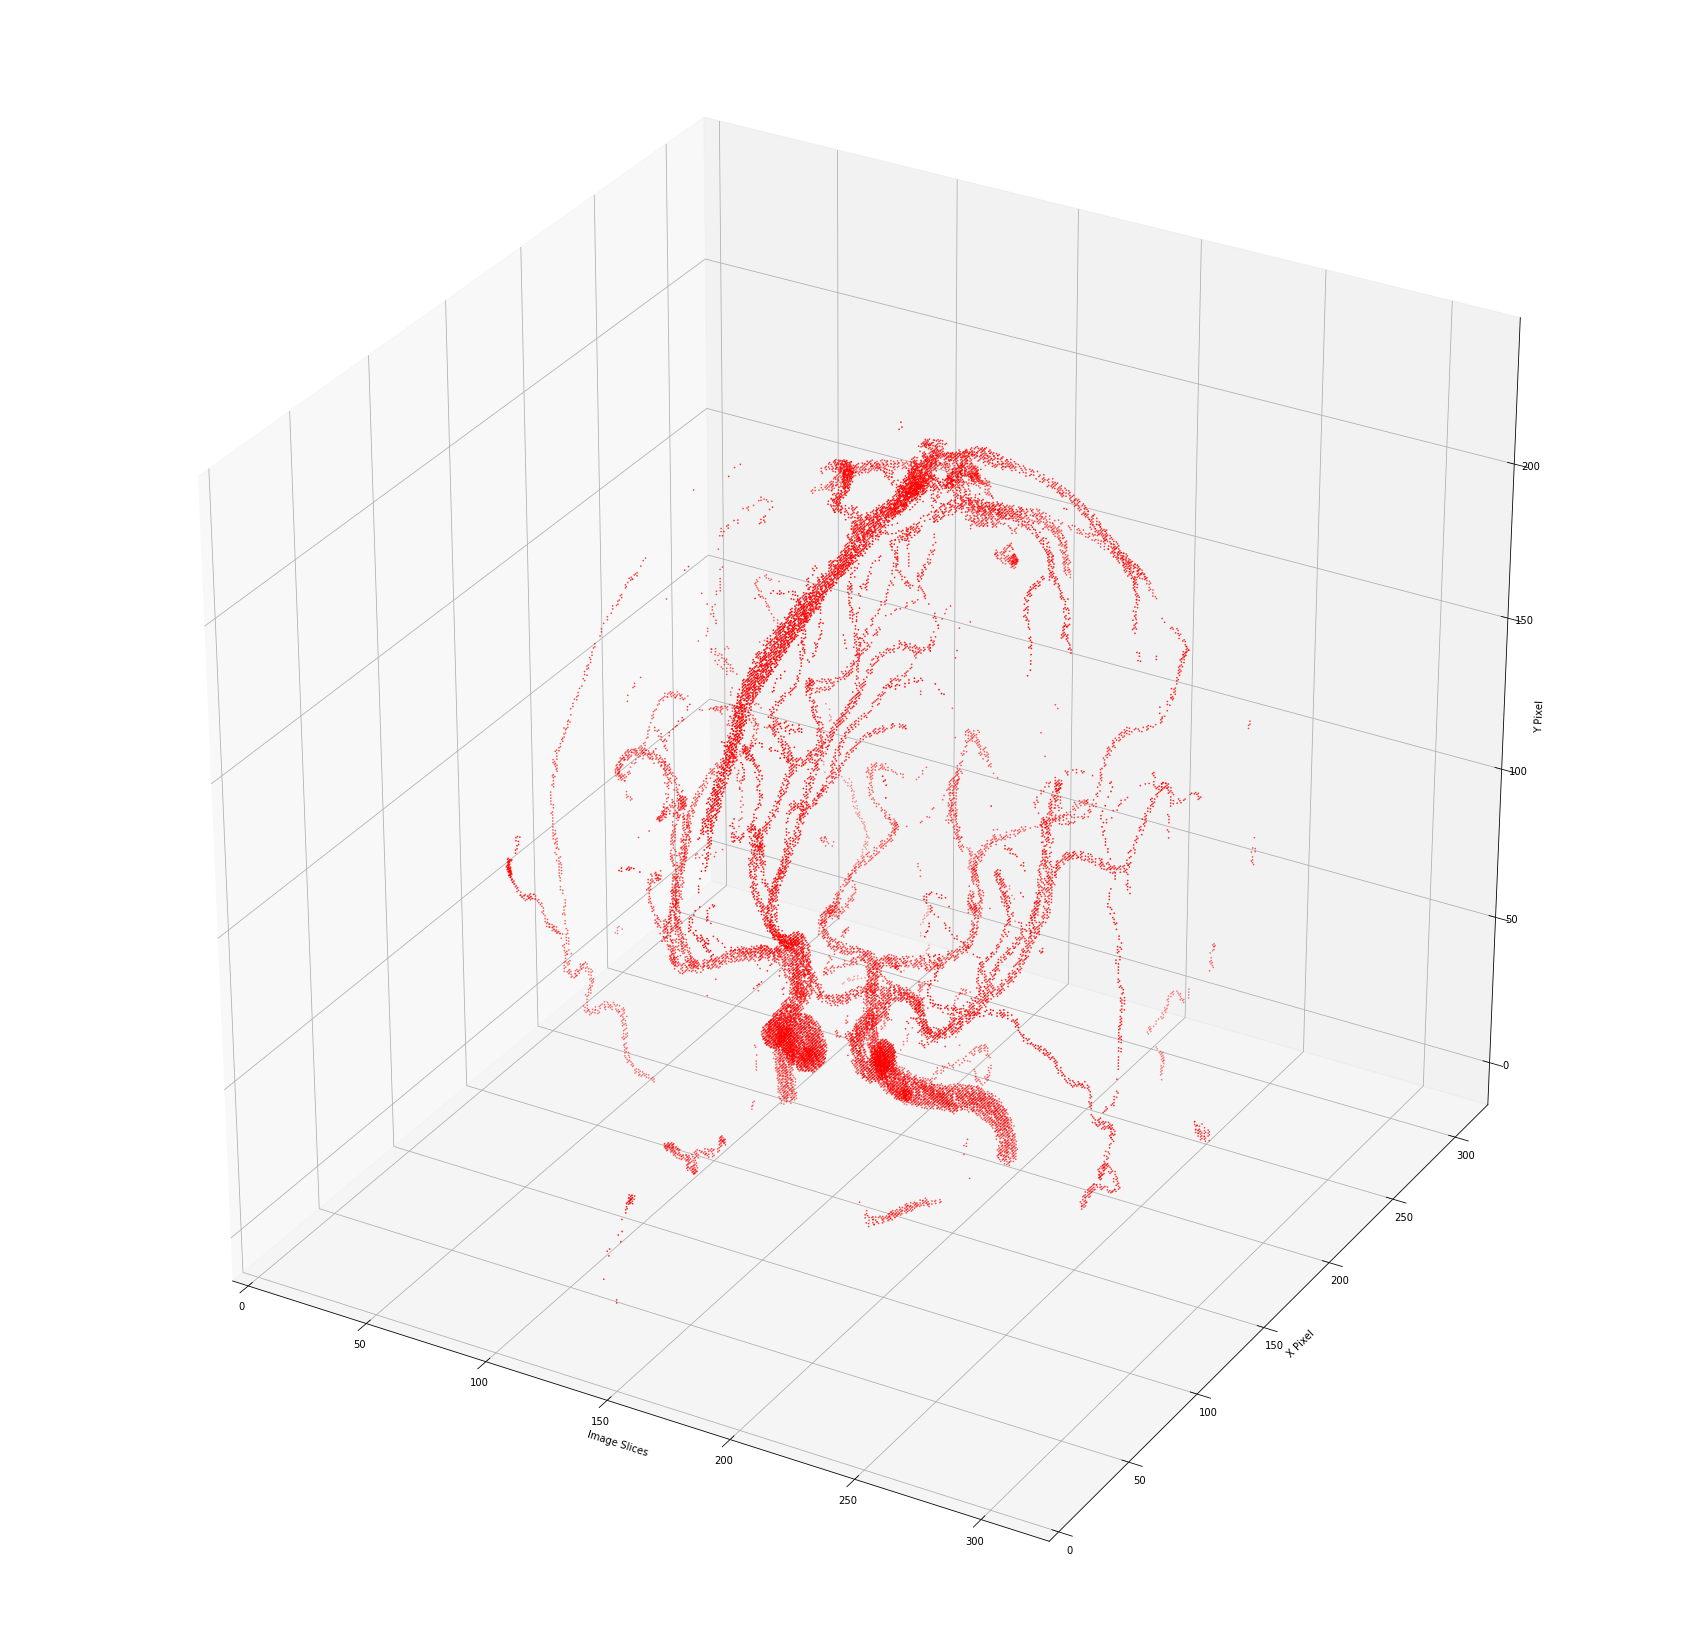

In [10]:
n_hits = 5
print('Minimum Number of hits: ' + str(n_hits))
print('******************************************')
b_map = (l_seg > n_hits - 1).astype(int)

ll = dict()
i = np.equal(b_map, 1)
ll[0] = np.where(i)

display_3d_image (ll, ['red'])

highlight differences between ground truth and segmented map

FN - Green  - (Blood vessel missed):                  34405
TP - Yellow - (Correctly classified as blood vessel): 22341
FP - Red    - (Wrongly classified as blood vessel):   1101
TN - Opaque - (Correctly classified as background):   25234953
***************************************************************
Total pixel number:                                   25292800
    
Precision:   95.3%
Recall:      39.37%
F1 Score:    55.72%
    


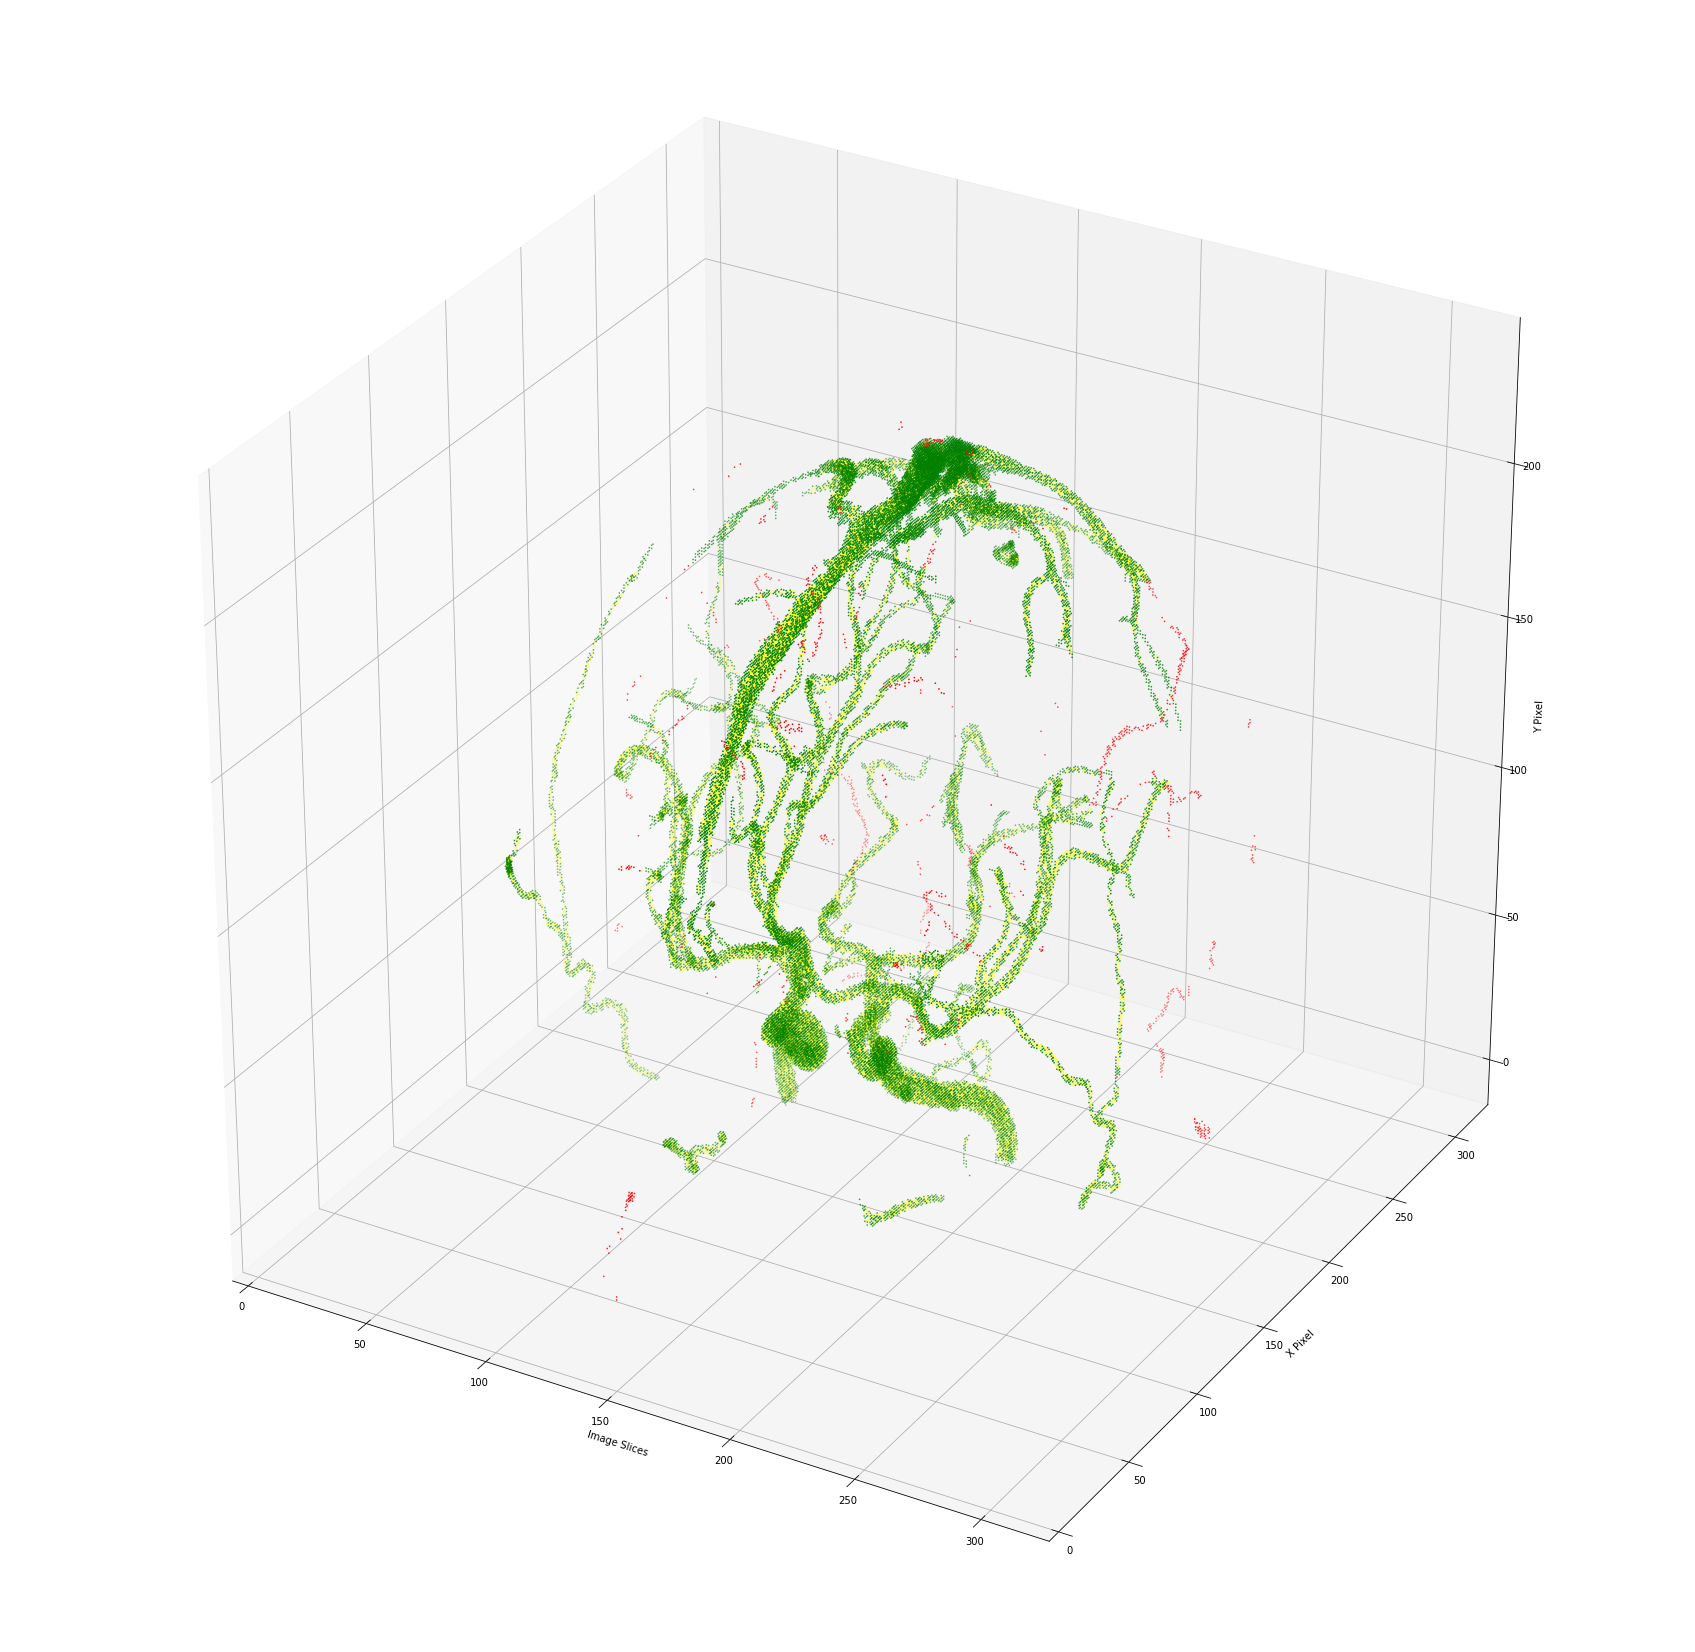

In [11]:
diff = l_gt - (b_map *2)

fn = (diff== 1).sum()
tp = (diff==-1).sum()
fp = (diff==-2).sum()
tn = (diff== 0).sum()
p  = tp / (tp + fp)  # precision 
r  = tp / (tp + fn)  # recall 
f1 = 2*p*r/(p+r)     # F1 score
print('FN - Green  - (Blood vessel missed):                  ' + str(fn) )
print('TP - Yellow - (Correctly classified as blood vessel): ' + str(tp) )
print('FP - Red    - (Wrongly classified as blood vessel):   ' + str(fp) )
print('TN - Opaque - (Correctly classified as background):   ' + str(tn) )
print('***************************************************************')
print('Total pixel number:                                   ' + str(fn+tp+fp+tn))
print('    ')
print('Precision:   ' + str(np.round(100*p,2))+'%')
print('Recall:      ' + str(np.round(100*r,2))+'%')
print('F1 Score:    ' + str(np.round(100*f1,2))+'%')
print('    ')

ll = dict()
idx = np.equal(diff, 1) # missed blood vessels
ll[0] = np.where(idx)

idx = np.equal(diff, -2) # wrongly assigned blood vessels
ll[1] = np.where(idx)


idx = np.equal(diff, -1) # correctly assigned blood vessels
ll[2] = np.where(idx)

display_3d_image (ll, ['green','red','yellow'])

In [12]:
n_map = b_map * 0 # initialise empty map with zeros 
idx = np.where(b_map == 1)
offset = [-1,0,1]

for x,y,z in zip(idx[0],idx[1],idx[2]): 
    for ox in offset:
        for oy in offset:
            for oz in offset: 
                try: 
                    n_map[x+ox,y+oy,z+oz] = n_map[x+ox,y+oy,z+oz] + 1 
                except IndexError:
                    pass # Ignore when pixels on the boundaries of the cube raise index errors


In [13]:
added = n_map * (l_src.astype(int) > app._pxl_threshold).astype(int)

In [14]:
k = 9
fixed_kn = np.sign(b_map + (added >= k).astype(np.uint16))

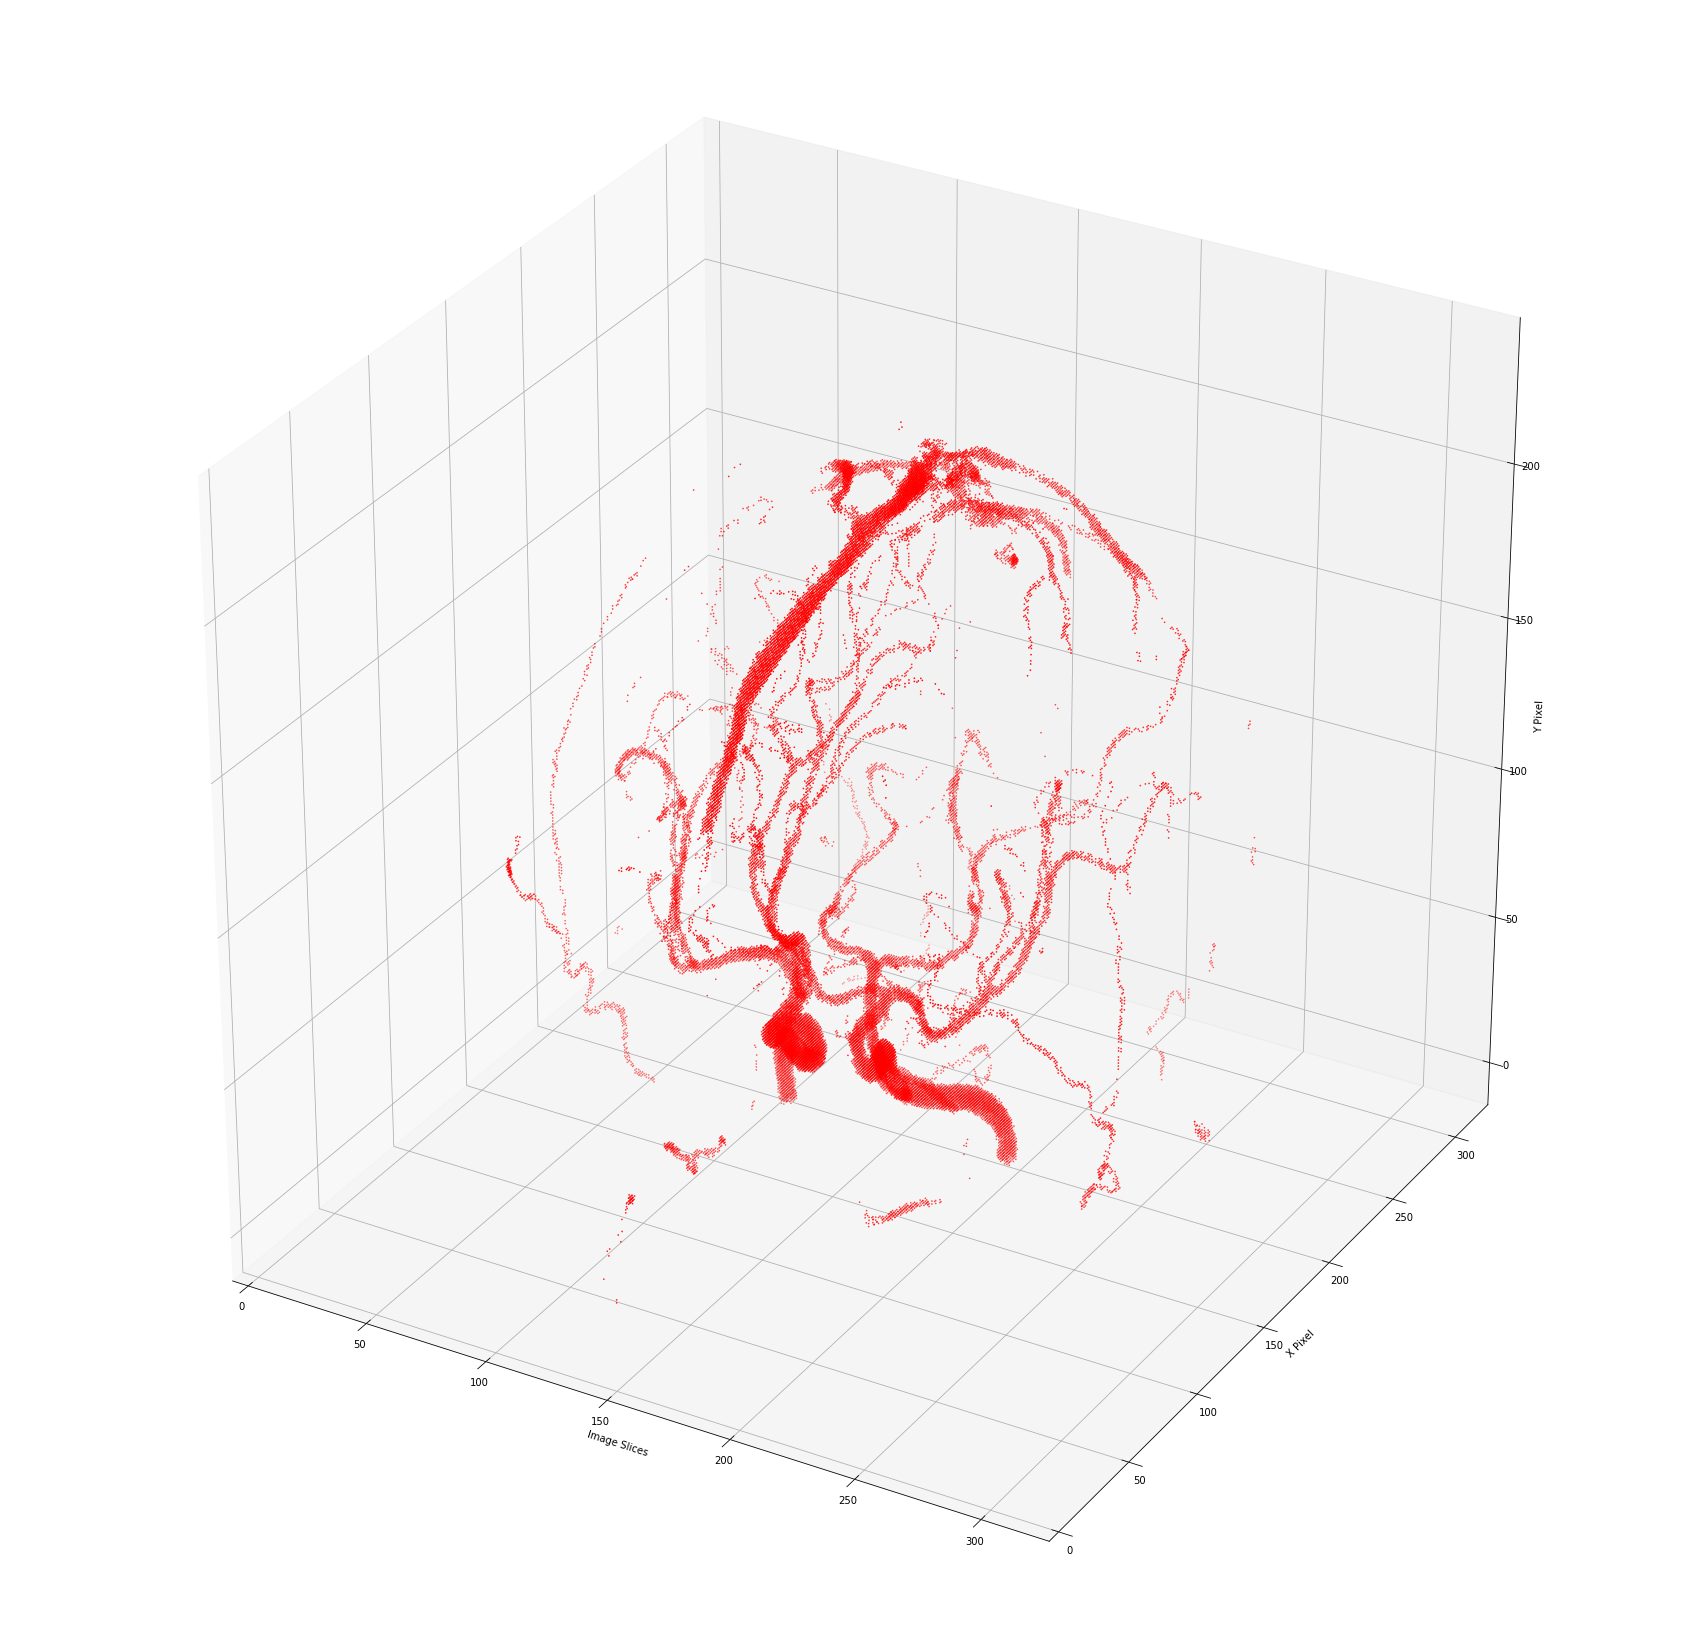

In [24]:
ll = dict()
idx = np.equal(fixed_kn, 1) # smoothened result
ll[0] = np.where(idx)

display_3d_image (ll, ['red'])

FN - Green  - (Blood vessel missed):                  24603
TP - Yellow - (Correctly classified as blood vessel): 32143
FP - Red    - (Wrongly classified as blood vessel):   1221
TN - Opaque - (Correctly classified as background):   25234833
***************************************************************
Total pixel number:                                   25292800
    
Precision:   96.34%
Recall:      56.64%
F1 Score:    71.34%
    


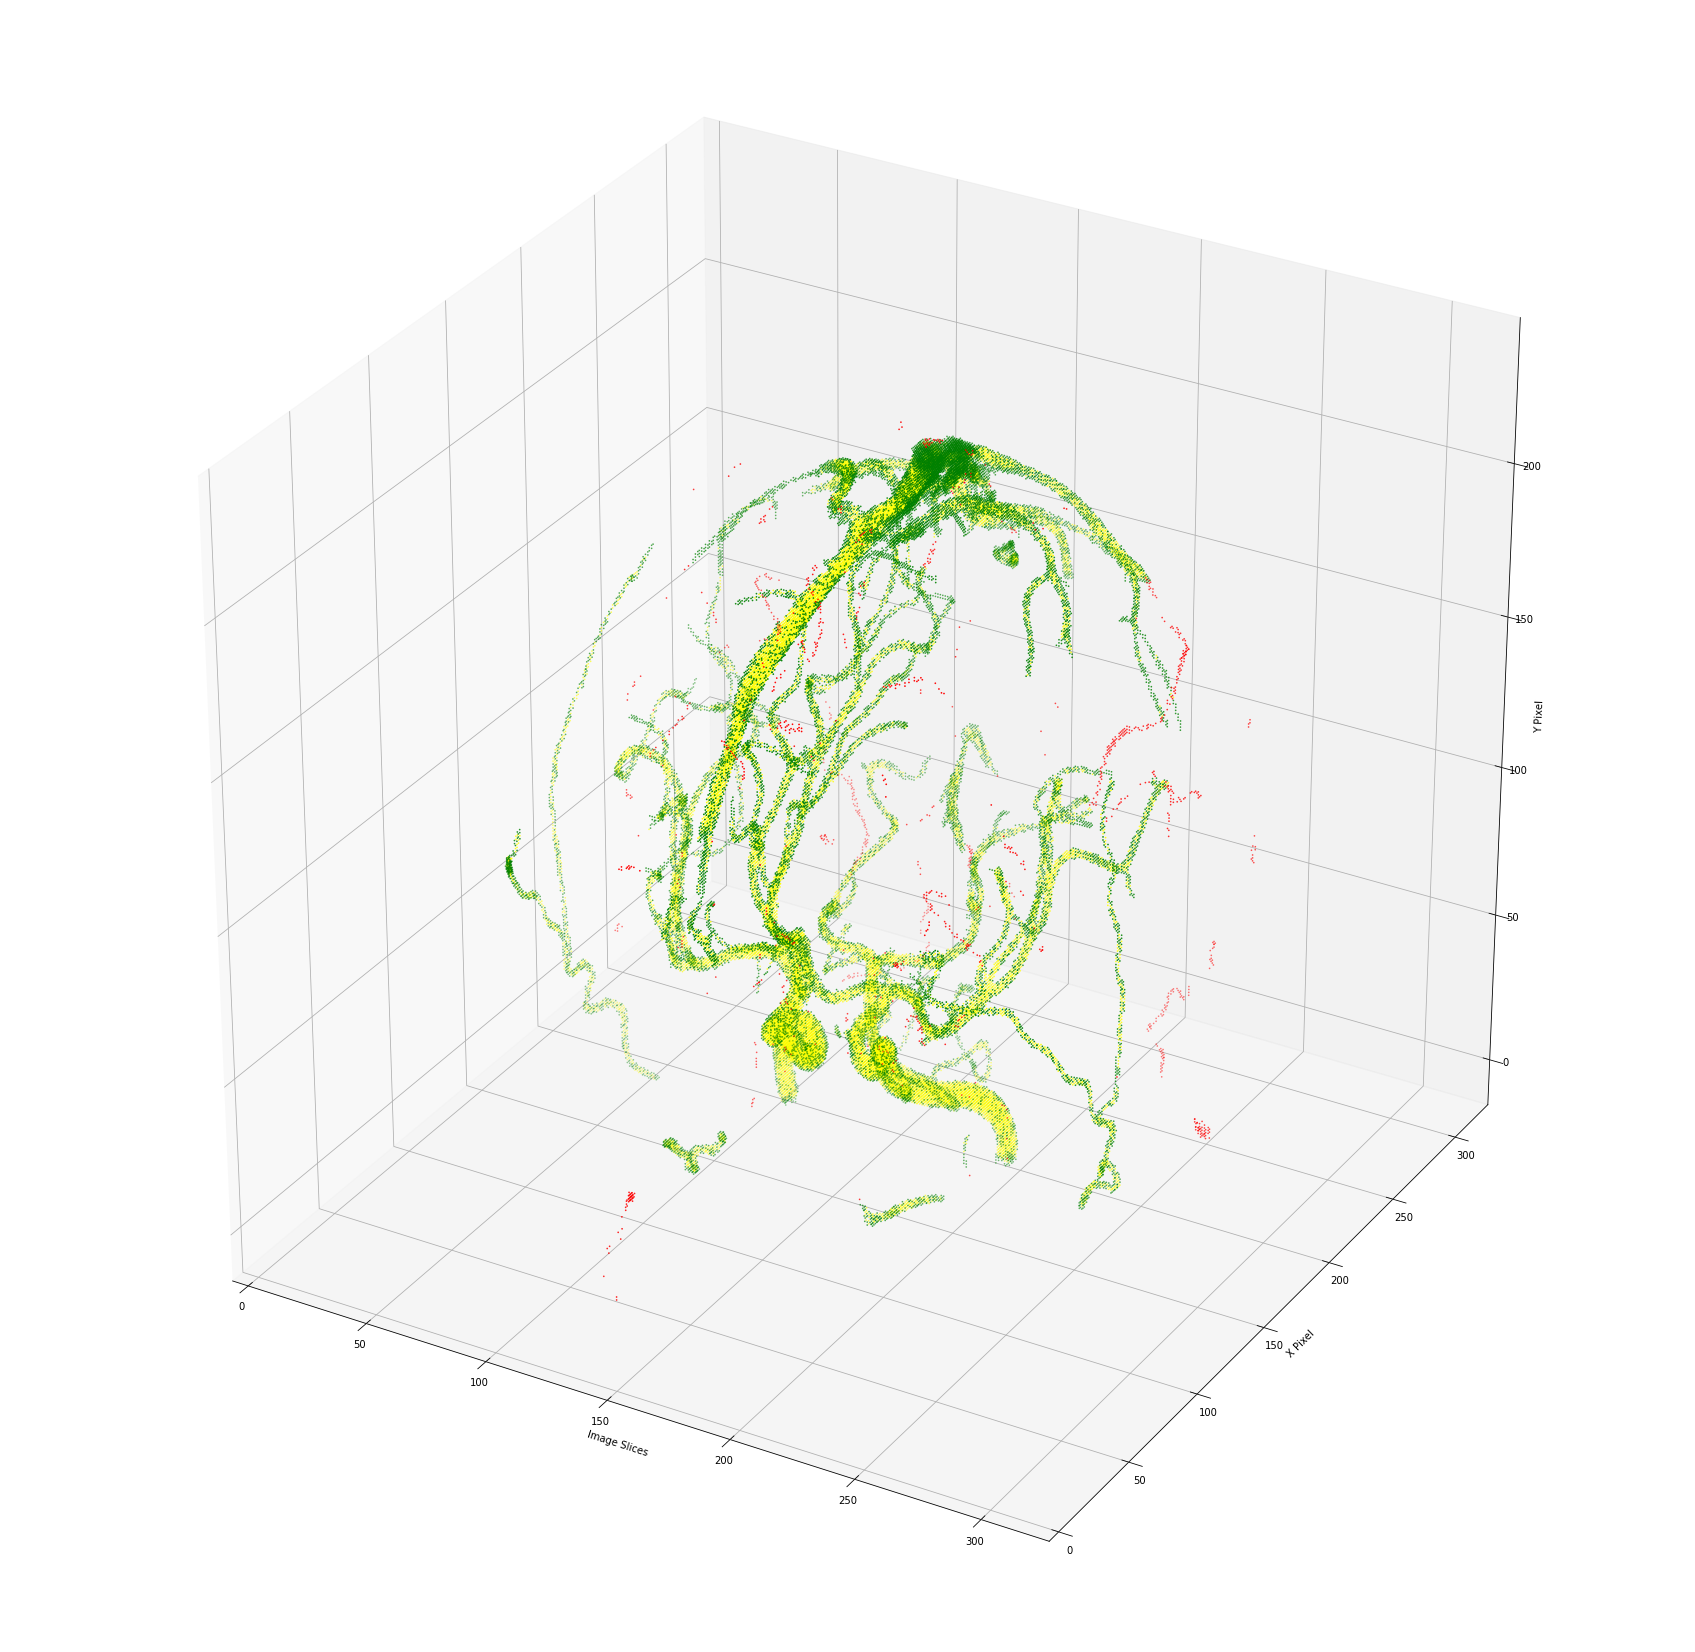

In [16]:
diff = l_gt - (fixed_kn *2)

fn = (diff== 1).sum()
tp = (diff==-1).sum()
fp = (diff==-2).sum()
tn = (diff== 0).sum()
p  = tp / (tp + fp)  # precision 
r  = tp / (tp + fn)  # recall 
f1 = 2*p*r/(p+r)     # F1 score
print('FN - Green  - (Blood vessel missed):                  ' + str(fn) )
print('TP - Yellow - (Correctly classified as blood vessel): ' + str(tp) )
print('FP - Red    - (Wrongly classified as blood vessel):   ' + str(fp) )
print('TN - Opaque - (Correctly classified as background):   ' + str(tn) )
print('***************************************************************')
print('Total pixel number:                                   ' + str(fn+tp+fp+tn))
print('    ')
print('Precision:   ' + str(np.round(100*p,2))+'%')
print('Recall:      ' + str(np.round(100*r,2))+'%')
print('F1 Score:    ' + str(np.round(100*2*p*r/(p+r),2))+'%')
print('    ')

ll = dict()
idx = np.equal(diff, 1) # missed blood vessels
ll[0] = np.where(idx)

idx = np.equal(diff, -2) # wrongly assigned blood vessels
ll[1] = np.where(idx)


idx = np.equal(diff, -1) # correctly assigned blood vessels
ll[2] = np.where(idx)

display_3d_image (ll, ['green','red','yellow'])

In [17]:
from scipy.ndimage import generate_binary_structure, binary_dilation

threshold_metrics = list() 

struct = generate_binary_structure(3, 2)
bbt = fixed_kn
filled_black_box = binary_dilation(bbt, structure=struct)
for signal_threshold in range(1,255): 
    fixed = filled_black_box * (l_src > signal_threshold).astype(int)
    
    diff = l_gt - (fixed *2)
    fn = (diff== 1).sum()
    tp = (diff==-1).sum()
    fp = (diff==-2).sum()
    tn = (diff== 0).sum()
    p  = tp / (tp + fp)  # precision 
    r  = tp / (tp + fn)  # recall 
    f1 = 2*p*r/(p+r)     # F1 score
    threshold_metrics.append([signal_threshold, np.round(100*p,2), np.round(100*r,2), np.round(100*f1,2)])
    print('Pixel Threshold:   ' + str(signal_threshold) )
    print('*******************************************')
    print('Precision:   ' + str(np.round(100*p,2))+'%')
    print('Recall:      ' + str(np.round(100*r,2))+'%')
    print('F1 Score:    ' + str(np.round(100*f1,2))+'%')
    print('    ')


Pixel Threshold:   1
*******************************************
Precision:   44.17%
Recall:      94.63%
F1 Score:    60.23%
    
Pixel Threshold:   2
*******************************************
Precision:   44.17%
Recall:      94.63%
F1 Score:    60.23%
    
Pixel Threshold:   3
*******************************************
Precision:   44.17%
Recall:      94.63%
F1 Score:    60.23%
    
Pixel Threshold:   4
*******************************************
Precision:   44.17%
Recall:      94.63%
F1 Score:    60.23%
    
Pixel Threshold:   5
*******************************************
Precision:   44.17%
Recall:      94.63%
F1 Score:    60.23%
    
Pixel Threshold:   6
*******************************************
Precision:   44.17%
Recall:      94.63%
F1 Score:    60.23%
    
Pixel Threshold:   7
*******************************************
Precision:   44.17%
Recall:      94.63%
F1 Score:    60.23%
    
Pixel Threshold:   8
*******************************************
Precision:   44.17%
Recal

Pixel Threshold:   64
*******************************************
Precision:   45.14%
Recall:      94.63%
F1 Score:    61.12%
    
Pixel Threshold:   65
*******************************************
Precision:   45.18%
Recall:      94.63%
F1 Score:    61.16%
    
Pixel Threshold:   66
*******************************************
Precision:   45.22%
Recall:      94.63%
F1 Score:    61.2%
    
Pixel Threshold:   67
*******************************************
Precision:   45.27%
Recall:      94.63%
F1 Score:    61.24%
    
Pixel Threshold:   68
*******************************************
Precision:   45.32%
Recall:      94.63%
F1 Score:    61.29%
    
Pixel Threshold:   69
*******************************************
Precision:   45.37%
Recall:      94.63%
F1 Score:    61.33%
    
Pixel Threshold:   70
*******************************************
Precision:   45.43%
Recall:      94.63%
F1 Score:    61.38%
    
Pixel Threshold:   71
*******************************************
Precision:   45.47

Pixel Threshold:   127
*******************************************
Precision:   52.98%
Recall:      94.63%
F1 Score:    67.92%
    
Pixel Threshold:   128
*******************************************
Precision:   53.2%
Recall:      94.63%
F1 Score:    68.11%
    
Pixel Threshold:   129
*******************************************
Precision:   53.46%
Recall:      94.63%
F1 Score:    68.32%
    
Pixel Threshold:   130
*******************************************
Precision:   53.71%
Recall:      94.63%
F1 Score:    68.52%
    
Pixel Threshold:   131
*******************************************
Precision:   53.98%
Recall:      94.63%
F1 Score:    68.74%
    
Pixel Threshold:   132
*******************************************
Precision:   54.22%
Recall:      94.63%
F1 Score:    68.94%
    
Pixel Threshold:   133
*******************************************
Precision:   54.47%
Recall:      94.63%
F1 Score:    69.14%
    
Pixel Threshold:   134
*******************************************
Precision:

Pixel Threshold:   190
*******************************************
Precision:   76.01%
Recall:      94.63%
F1 Score:    84.3%
    
Pixel Threshold:   191
*******************************************
Precision:   76.52%
Recall:      94.63%
F1 Score:    84.61%
    
Pixel Threshold:   192
*******************************************
Precision:   76.98%
Recall:      94.63%
F1 Score:    84.89%
    
Pixel Threshold:   193
*******************************************
Precision:   77.51%
Recall:      94.63%
F1 Score:    85.21%
    
Pixel Threshold:   194
*******************************************
Precision:   78.0%
Recall:      94.63%
F1 Score:    85.51%
    
Pixel Threshold:   195
*******************************************
Precision:   78.52%
Recall:      94.63%
F1 Score:    85.82%
    
Pixel Threshold:   196
*******************************************
Precision:   79.04%
Recall:      94.63%
F1 Score:    86.13%
    
Pixel Threshold:   197
*******************************************
Precision: 

Pixel Threshold:   253
*******************************************
Precision:   94.6%
Recall:      48.19%
F1 Score:    63.85%
    
Pixel Threshold:   254
*******************************************
Precision:   94.53%
Recall:      42.36%
F1 Score:    58.5%
    


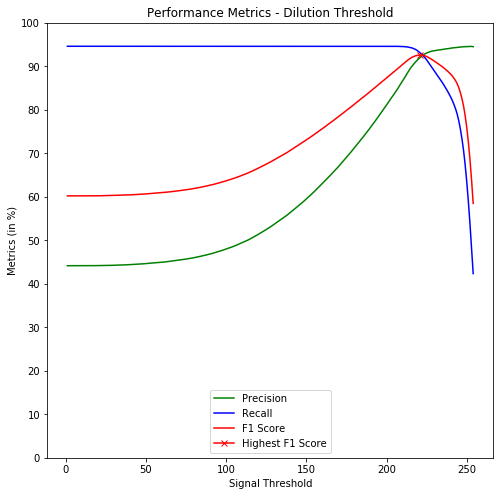

In [18]:
plt.figure(figsize=(8, 8))
plt.title("Performance Metrics - Dilution Threshold")
c = threshold_metrics
x = np.asarray(list([i[0] for i in c]))
p = np.asarray(list([i[1] for i in c]))
r = np.asarray(list([i[2] for i in c]))
f = np.asarray(list([i[3] for i in c]))
plt.plot(x,p, color="g", label="Precision")
plt.plot(x,r, color="b", label="Recall")
plt.plot(x,f, color="r", label="F1 Score")
plt.plot( x[np.argmax(f)], np.max(f), marker="x", color="r", label="Highest F1 Score")
#plt.xticks(range(27))
plt.xlabel("Signal Threshold")
#plt.ylim(0,100)
plt.yticks(range(0, 110, 10))
plt.ylabel("Metrics (in %)")
plt.legend(loc='lower center')

The optimal threshold (highest F1 score) is achieved with a pixel value above 241. This value is used to calculate the final segmentation map for the manually segmented cerebral MRA scan.

FN - Green  - (Blood vessel missed):                  10122
TP - Yellow - (Correctly classified as blood vessel): 46624
FP - Red    - (Wrongly classified as blood vessel):   2846
TN - Opaque - (Correctly classified as background):   25233208
***************************************************************
Total pixel number:                                   25292800
    
Precision:   94.25%
Recall:      82.16%
F1 Score:    87.79%
    


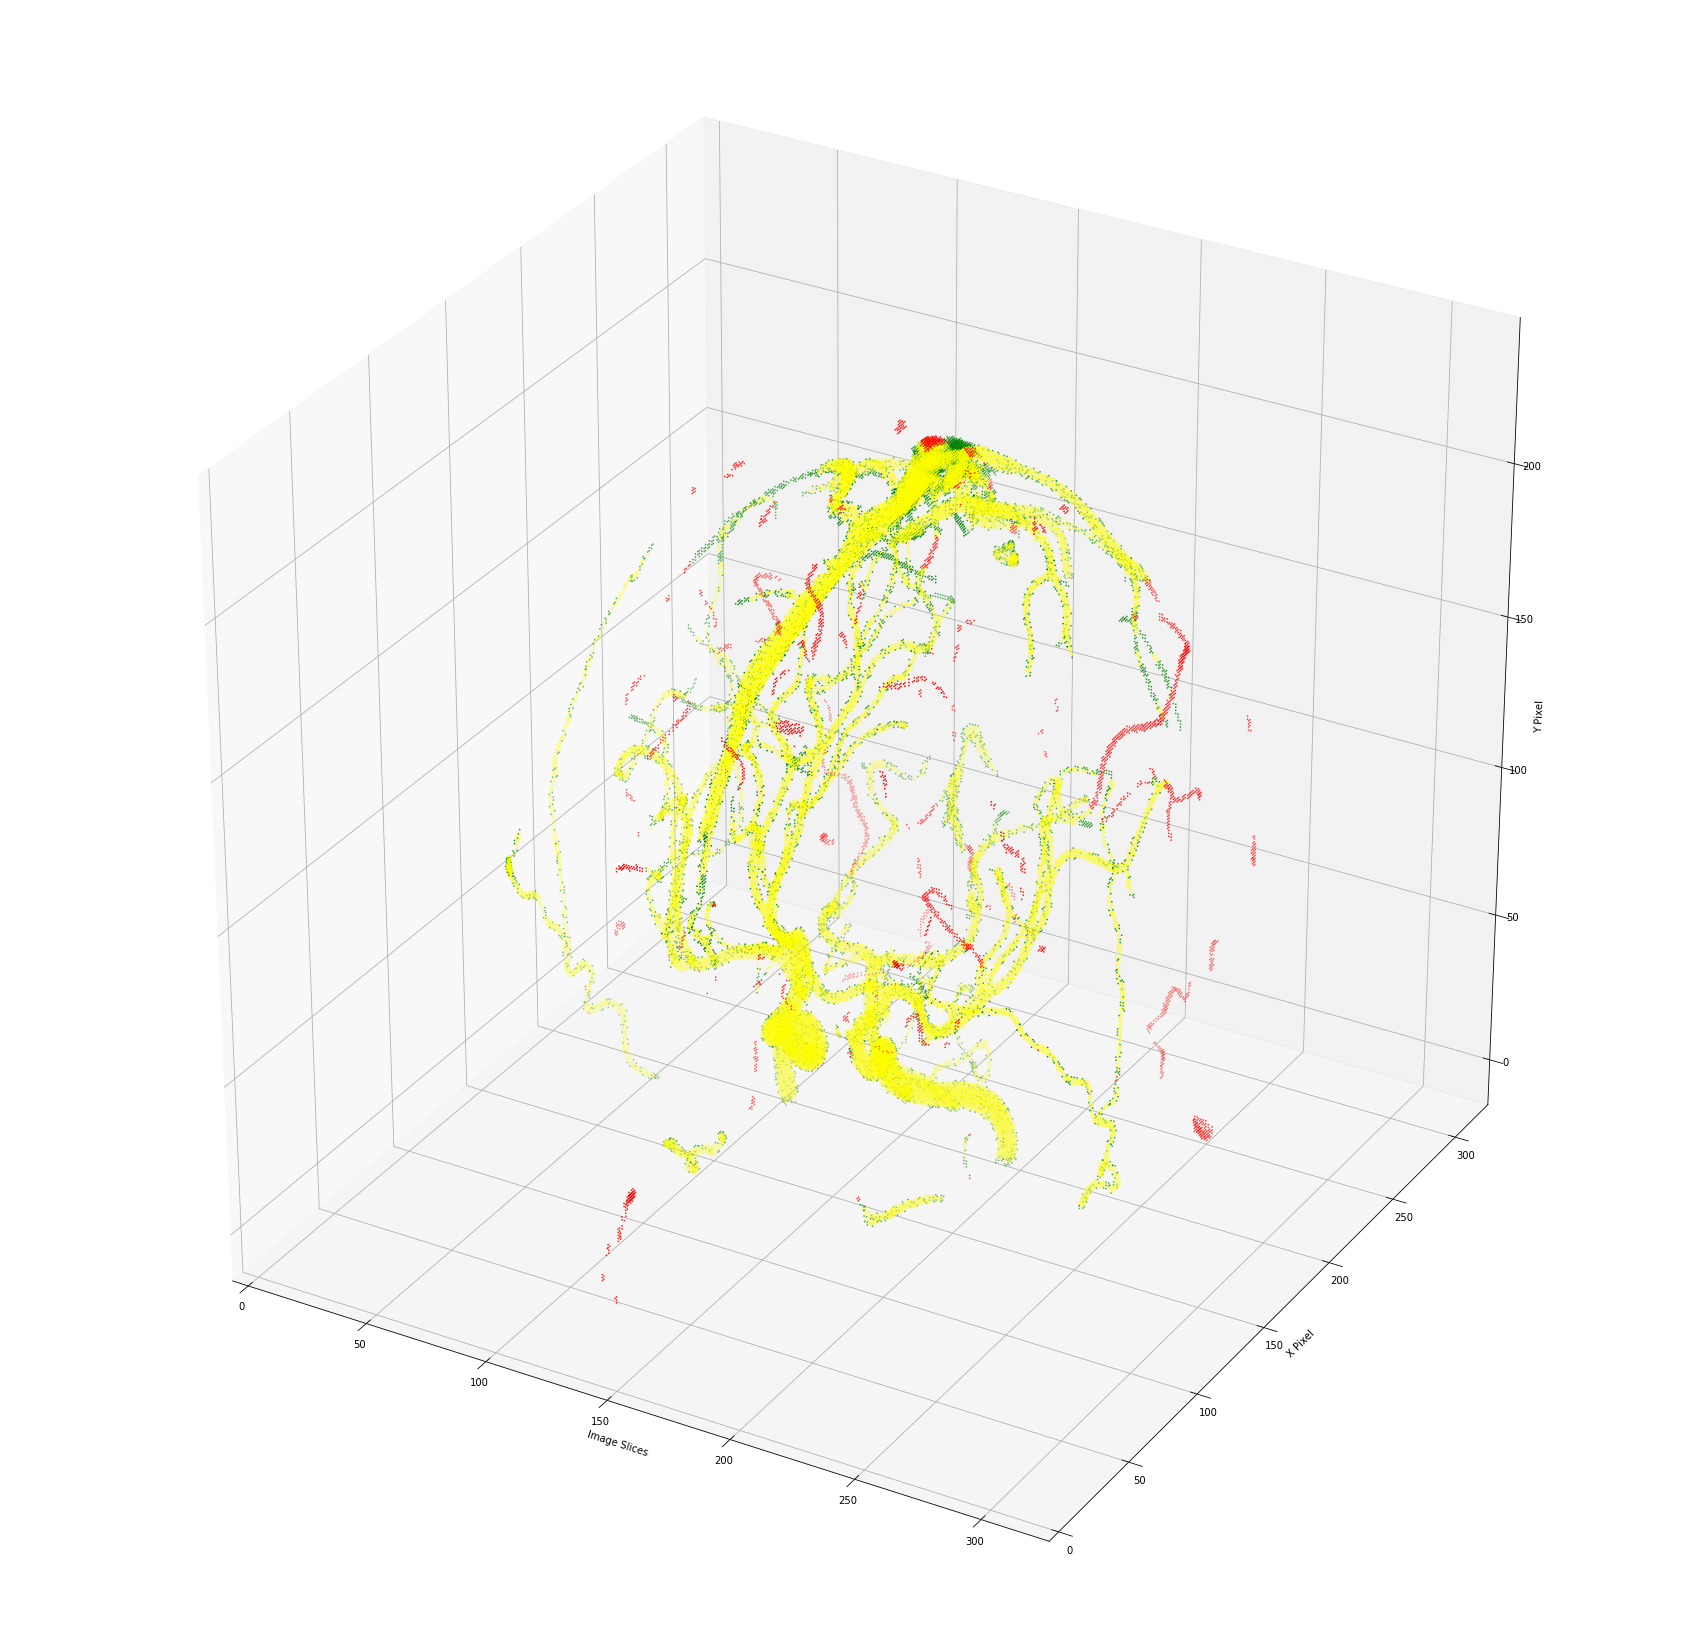

In [20]:
from scipy.ndimage import generate_binary_structure, binary_dilation
signal_threshold = 241
bbt = fixed_kn 
struct = generate_binary_structure(3, 2)
filled_black_box = binary_dilation(bbt, structure=struct)

fixed = filled_black_box * (l_src > signal_threshold).astype(int)

diff = l_gt - (fixed *2)

fn = (diff== 1).sum()
tp = (diff==-1).sum()
fp = (diff==-2).sum()
tn = (diff== 0).sum()
p  = tp / (tp + fp)  # precision 
r  = tp / (tp + fn)  # recall 
f1 = 2*p*r/(p+r)     # F1 score
print('FN - Green  - (Blood vessel missed):                  ' + str(fn) )
print('TP - Yellow - (Correctly classified as blood vessel): ' + str(tp) )
print('FP - Red    - (Wrongly classified as blood vessel):   ' + str(fp) )
print('TN - Opaque - (Correctly classified as background):   ' + str(tn) )
print('***************************************************************')
print('Total pixel number:                                   ' + str(fn+tp+fp+tn))
print('    ')
print('Precision:   ' + str(np.round(100*p,2))+'%')
print('Recall:      ' + str(np.round(100*r,2))+'%')
print('F1 Score:    ' + str(np.round(100*f1,2))+'%')
print('    ')


ll = dict()
idx = np.equal(diff, 1) # missed blood vessels
ll[0] = np.where(idx)

idx = np.equal(diff, -2) # wrongly assigned blood vessels
ll[1] = np.where(idx)


idx = np.equal(diff, -1) # correctly assigned blood vessels
ll[2] = np.where(idx)

display_3d_image (ll, ['green','red','yellow'])


End of this project component